# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

Краткие резульаты:
В рамках работы были применены следующие техники и алгоритмы:
- Логарифмирование целевой переменной price (помогло)
- Создание нового признака distance_to_manhattan (помогло)
- Удаление выбросов цены > $500 (помогло)
- One-Hot Encoding категориальных признаков room_type, neighbourhood_group (помогло)
- Использование RobustScaler (помогло)

Создание признака distance_to_manhattan привело к 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.spatial.distance import euclidean
from statsmodels.distributions.empirical_distribution import ECDF

# Загрузка и очистка данных

In [45]:
df = pd.read_csv('AB_NYC_2019.csv')
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
df = df.drop(columns=cols_to_drop)

# Просмотр данных после очистки

In [46]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


8   reviews_per_month               38843 non-null  float64 - содержит пропуски. Заменим пропуски.

In [47]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Визуализация распределений

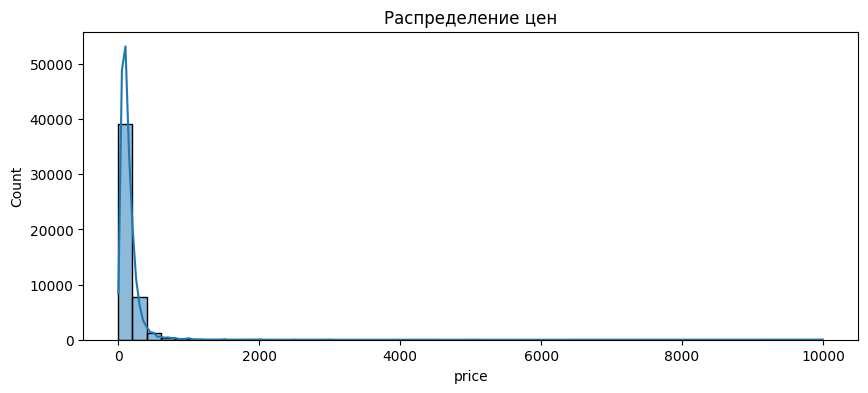

In [48]:
plt.figure(figsize=(10, 4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Распределение цен')
plt.show()

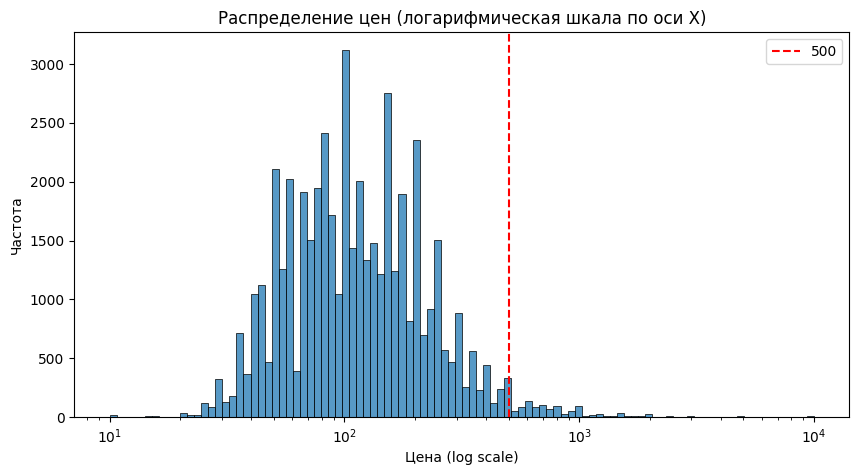

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=False, log_scale=(True, False))
plt.title('Распределение цен (логарифмическая шкала по оси X)')
plt.xlabel('Цена (log scale)')
plt.ylabel('Частота')
plt.axvline(500, color='red', linestyle='--', label='500')
plt.legend()
plt.show()

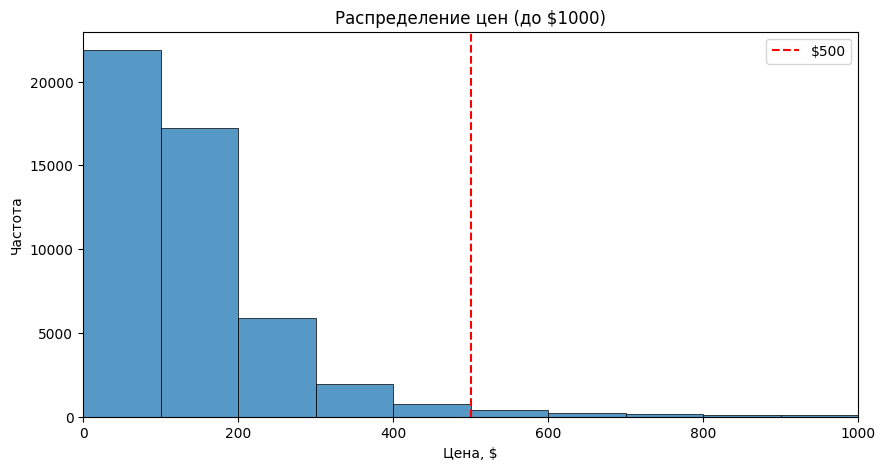

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=False)
plt.xlim(0, 1000)
plt.title('Распределение цен (до $1000)')
plt.xlabel('Цена, $')
plt.ylabel('Частота')
plt.axvline(500, color='red', linestyle='--', label='$500')
plt.legend()
plt.show()

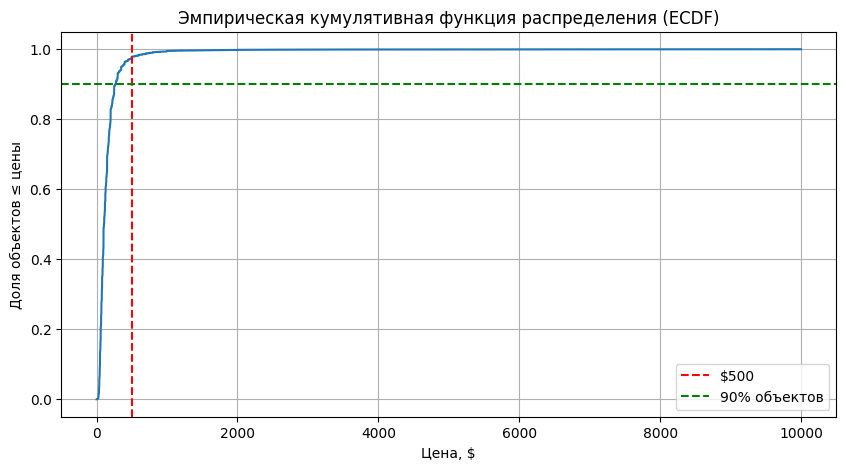

In [51]:
ecdf = ECDF(df['price'])
plt.figure(figsize=(10, 5))
plt.plot(ecdf.x, ecdf.y)
plt.axvline(500, color='red', linestyle='--', label='$500')
plt.axhline(0.9, color='green', linestyle='--', label='90% объектов')
plt.title('Эмпирическая кумулятивная функция распределения (ECDF)')
plt.xlabel('Цена, $')
plt.ylabel('Доля объектов ≤ цены')
plt.legend()
plt.grid(True)
plt.show()

Из графиков мы видим, что большая часть аренд стоит до 500$ (90% до 300).

# Матрица корреляций

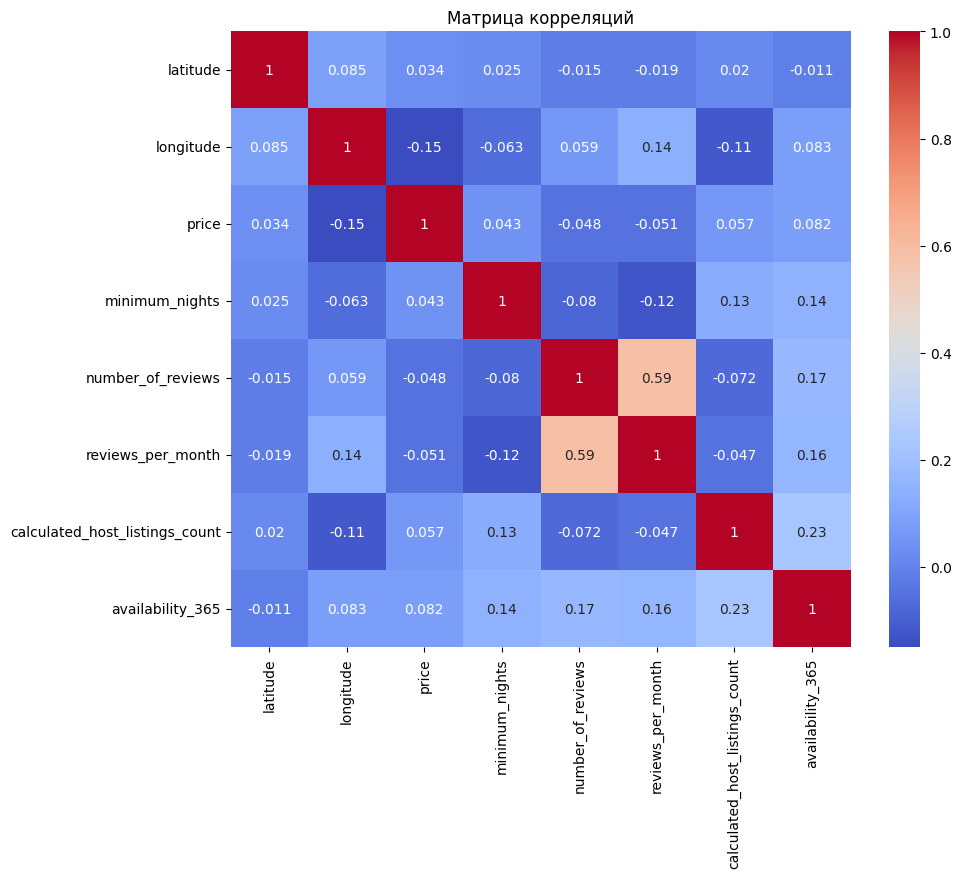

In [52]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

Основные выводы:
- Цена слабо зависит от расположение в координатах. Возможно стоит использовать расстояние до Манхэттена
- Цена слабо коррелирует с числовыми значениями параметров. Стоит использовать логарифмическое значение цены
- Стоит использовать признаки категорий номеров. Это улучшит понимание соотношения цен.

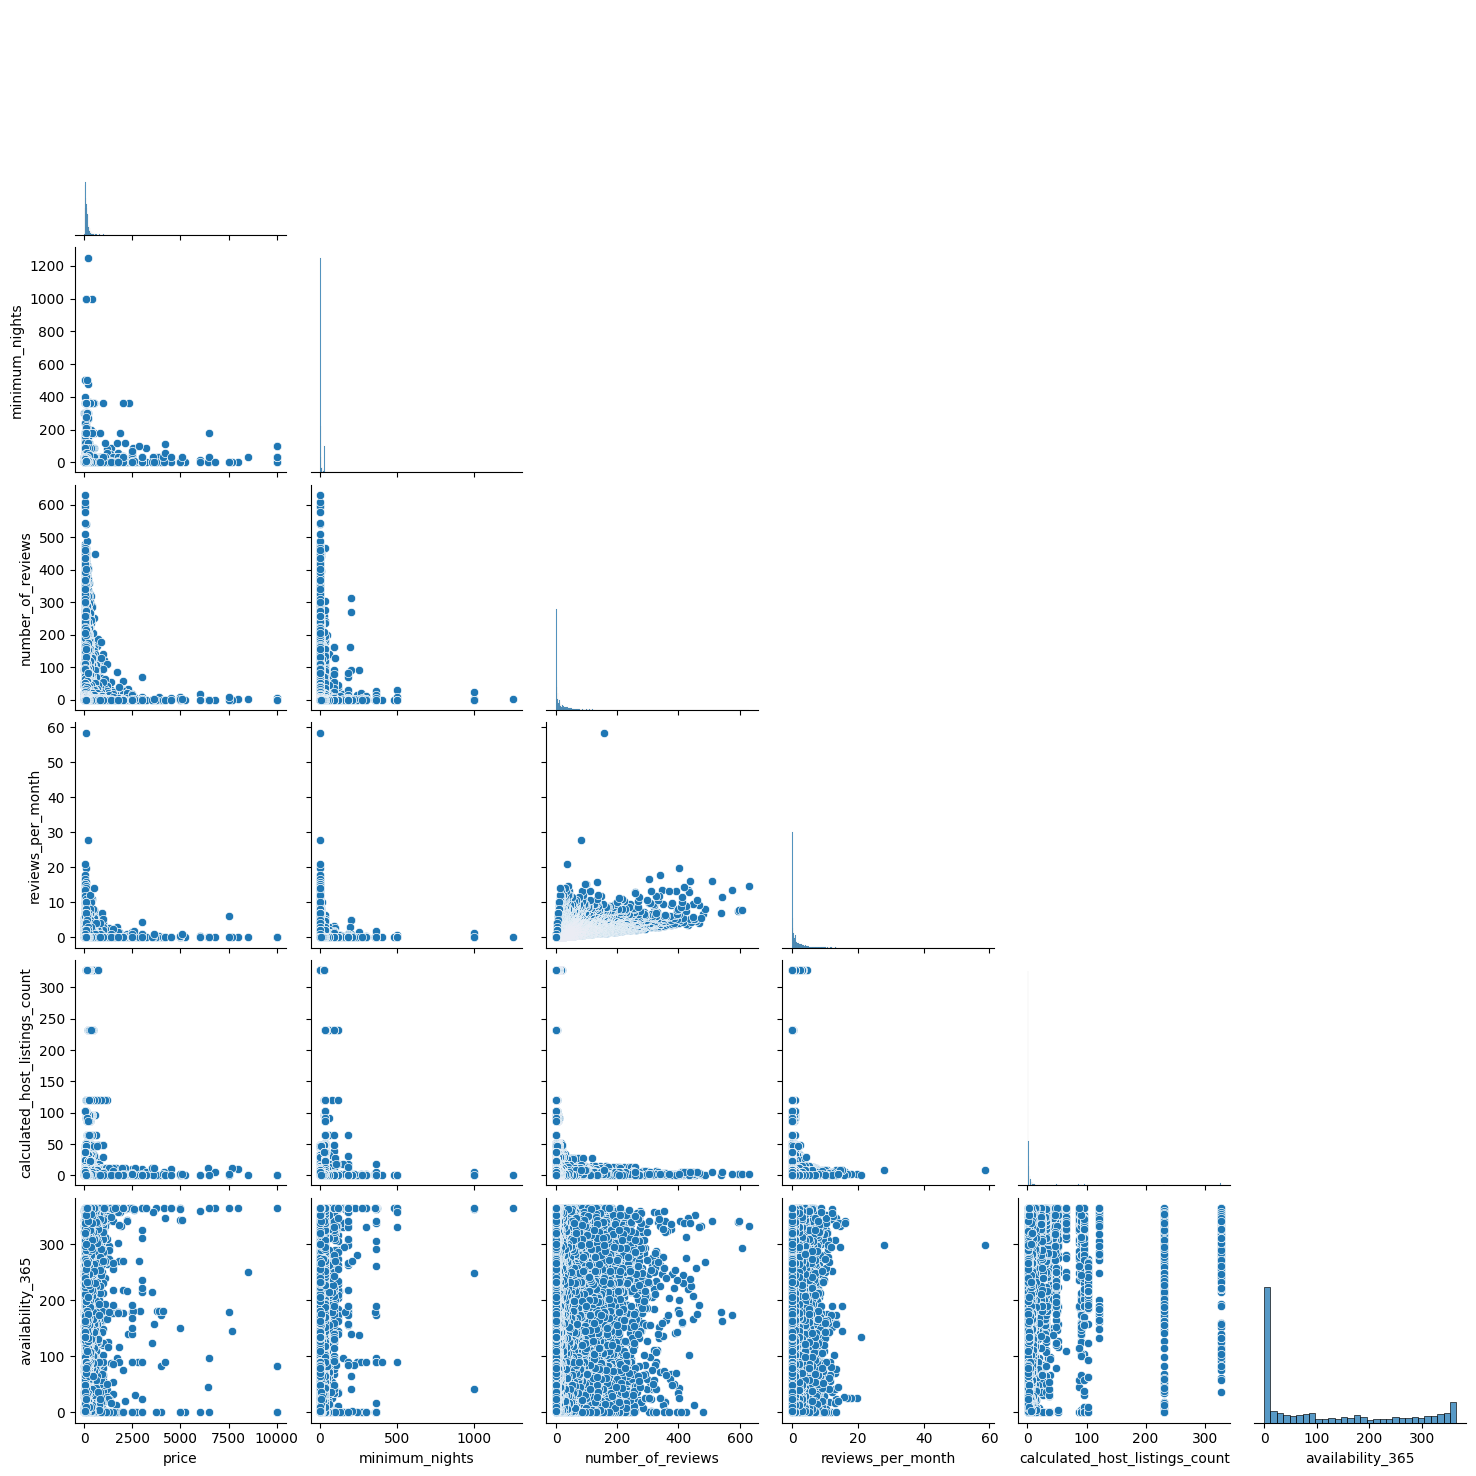

In [53]:
sns.pairplot(df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']], corner=True)
plt.show()

# Часть 2. Preprocessing & Feature Engineering

In [54]:
df = df[(df['price'] >= 10) & (df['price'] <= 500)] # Возьмем диапазон цен от 10 до 500$

In [55]:
def euclidean_distance(lat1, lon1, lat2=40.7831, lon2=-73.9712): # Расстояние до центра
    return euclidean([lat1, lon1], [lat2, lon2])

df['distance_to_manhattan'] = df.apply(
    lambda row: euclidean_distance(row['latitude'], row['longitude']), axis=1
)

In [56]:
# df = df.drop(columns=['latitude', 'longitude']) # Убираем старые значения координат

In [57]:
categorical_features = ['neighbourhood_group', 'room_type'] # добавляем категории
df = df.drop(columns=['neighbourhood'])  # убираем 'neighbourhood' тк слишком много уникальных значений

In [58]:
df['log_price'] = np.log1p(df['price'])
y_col = 'log_price'  # предсказываем логарифм цены

# Часть 3. Моделирование

In [59]:
X = df.drop(columns=['price', 'log_price'])
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),  # RobustScaler устойчив к выбросам
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [61]:
models = {
    'LinearRegression': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-3, 3, 50)),
    'LassoCV': LassoCV(alphas=np.logspace(-3, 0, 30), cv=5, random_state=42),
    'ElasticNetCV': ElasticNetCV(alphas=np.logspace(-3, 0, 30), l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    # Обратное преобразование логарифма
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
    
    r2 = r2_score(y_test_exp, y_pred_exp)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    
    results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
    print(f"{name}: R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

LinearRegression: R²=0.402, MAE=43.30, RMSE=68.58
RidgeCV: R²=0.402, MAE=43.30, RMSE=68.58
LassoCV: R²=0.399, MAE=43.35, RMSE=68.76
ElasticNetCV: R²=0.401, MAE=43.31, RMSE=68.67


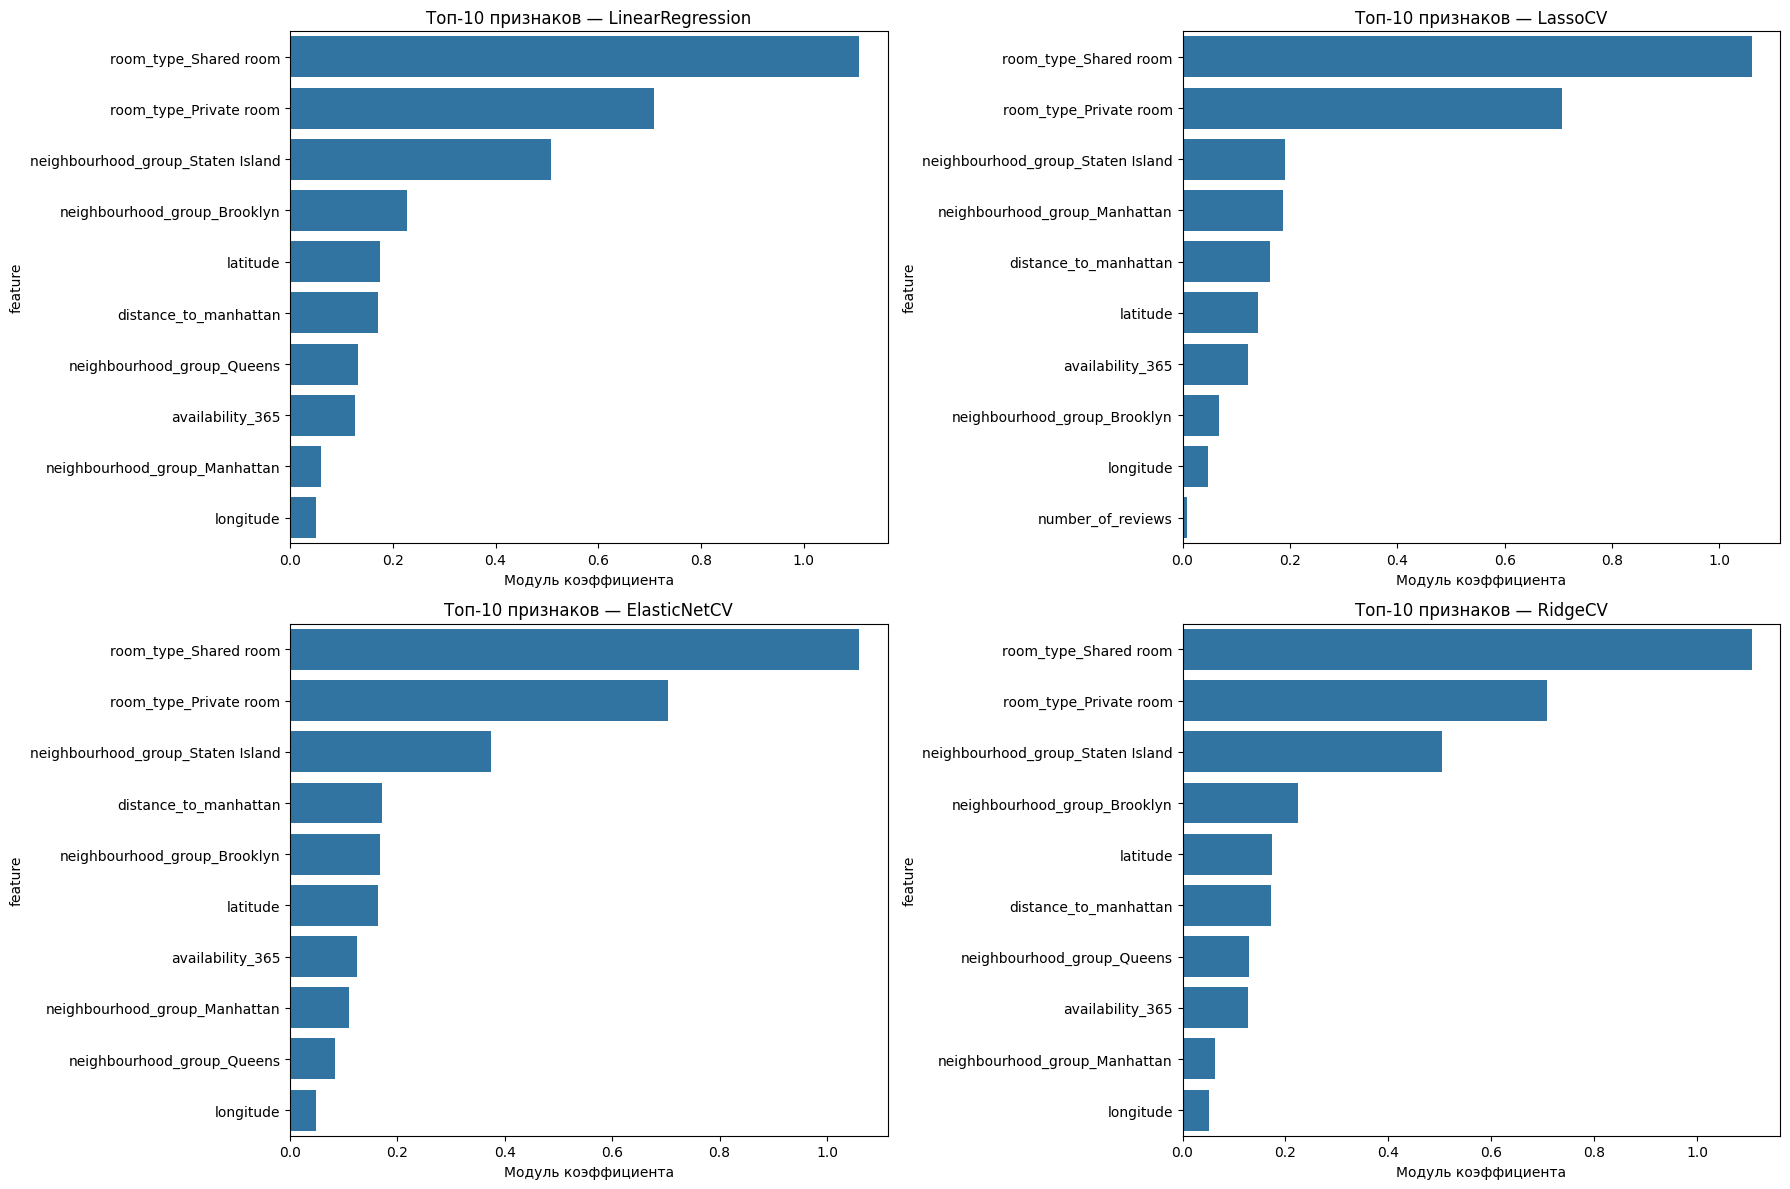

In [63]:
models_to_plot = {
    'LinearRegression': LinearRegression(),
    'LassoCV': LassoCV(alphas=np.logspace(-3, 0, 30), cv=5, random_state=42),
    'ElasticNetCV': ElasticNetCV(alphas=np.logspace(-3, 0, 30), l1_ratio=[0.1, 0.5, 0.9], cv=5, random_state=42),
    'RidgeCV': RidgeCV(alphas=np.logspace(-3, 3, 50))
}

# Подготовим общие feature_names один раз (на примере первой модели)
# (все модели используют один и тот же preprocessor)
pipeline_temp = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_temp.fit(X_train, y_train)
feature_names = (
    numeric_features +
    list(pipeline_temp.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

# Построим графики по одной модели за раз
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models_to_plot.items()):
    # Обучаем пайплайн
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    
    # Извлекаем коэффициенты
    coef = pipeline.named_steps['regressor'].coef_
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'coef': np.abs(coef)
    }).sort_values('coef', ascending=False).head(10)
    
    # Строим barplot
    sns.barplot(data=feat_imp, x='coef', y='feature', ax=axes[idx])
    axes[idx].set_title(f'Топ-10 признаков — {name}')
    axes[idx].set_xlabel('Модуль коэффициента')

plt.tight_layout()
plt.show()

Результаты:
Лучше всего справились модели: LinearRegression, RidgeCV
ElasticNetCV - результат незначительно хуже, чем у RidgeCV и LinearRegression
LassoCV - предоставил результат хуже остальных. 